# 0.0. IMPORTS

In [1]:
import pandas as pd
import inflection
import math
import numpy as np
import seaborn as sns
import pathlib
import seaborn as sns
import ast
import lightgbm as lgb
import xgboost as xgb
from scipy.stats       import chi2_contingency
from category_encoders import TargetEncoder
from sklearn          import preprocessing as pp
import pickle
import os

from xgboost                  import XGBRegressor
from lightgbm                 import LGBMRegressor
from geopy.geocoders          import Nominatim
from sqlalchemy               import create_engine, text
from matplotlib               import pyplot as plt
from sklearn.preprocessing    import RobustScaler, MinMaxScaler, LabelEncoder
from boruta                   import BorutaPy
from sklearn.ensemble         import RandomForestRegressor
from sklearn.model_selection  import train_test_split
from sklearn.linear_model     import LinearRegression,  Lasso
from sklearn.metrics          import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error,r2_score
from sklearn.model_selection  import cross_val_score
from sklearn.preprocessing    import LabelEncoder
from sklearn.model_selection  import KFold

## 0.1.0 Helper Functions

In [2]:
# função para consultar a api passando as coordenadas
def find_mun( lat,long ):
    
    geolocator = Nominatim(user_agent="Oscar")
    
    lat = str( lat )
    
    long = str( long )
    
    coord = lat + ',' + long

    location = geolocator.reverse( coord  )
    
    if 'city_district' in location.raw['address']:
        
        return location.raw['address']['city_district']
        
    if 'suburb' in location.raw['address']:
            
        return location.raw['address']['suburb']
            
    if 'county' in location.raw['address']:
            
        return location.raw['address']['county']
        
    else:
        
        return 'not found'

  
def stats( df , excepto = [] ):
    # separo as feautures numéricas
    if excepto != "":
    
        num_attributes = df.select_dtypes( include = ['int64','float64'] )
        
        num_attributes = num_attributes.drop( excepto , axis = 1 ) 
        
    else:
        
        num_attributes = df.select_dtypes( include = ['int64','float64'] )
    # separo as features categoricas
    num_categorical = df.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )


    # medidas de tendencia central - media e mediana
    ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T # media

    ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T # mediana

    # dispersao - std, min , max , range, skew, kurtosis
    d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T # std
    d2 = pd.DataFrame( num_attributes.apply( np.min ) ).T # minimo
    d3 = pd.DataFrame( num_attributes.apply( np.max ) ).T # maximo
    d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T # range
    d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() )).T # skew
    d6 = pd.DataFrame( num_attributes.apply( lambda x : x.kurtosis() ) ).T # kurtosis

    # concatenate - min , max , range,  media, median, std, skew , kurtosis
    m = pd.concat( [ d2 , d3, d4 , ct1 , ct2 , d1,  d5 , d6 ] ).T.reset_index()
    m.columns = [ 'features', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis' ]
    pd.set_option( 'display.float_format', '{:,.2f}'.format )
    return m

def ml_error( model_name, y , y_hat):
    mae =  mean_absolute_error( y , y_hat )
    mape = mean_absolute_percentage_error( y , y_hat )
    rmse = np.sqrt( mean_squared_error( y , y_hat ) )
    r2 =   r2_score(y, y_hat)
    df = pd.DataFrame( {'Model Name ' :  model_name,
                        'MAE' : mae ,
                        'MAPE' : mape,
                        'RMSE' : rmse,
                        'R2_score' : r2  } ,index = [0] )
    
    return df

def remover_outliers( df, coluna ):
    
    linhas_iniciais = df.shape[0] 
    
    
    d1 = df[coluna].quantile(0.25)
    d3 = df[coluna].quantile(0.75)

    lim_superior = d3 + 1.5*( d3 - d1  )

    lim_inferior = d1 - 1.5 * ( d3 - d1 )
    
    
    df = df.loc[ (df[coluna] >= lim_inferior) & (df[coluna] <= lim_superior) , :  ]
    
    linhas_finais = df.shape[0]
    
    
    print('Foram removidas {} linhas'.format( linhas_iniciais - linhas_finais ) )
          
    return df

def cramer_v( x, y ):
    cm = pd.crosstab( x , y ).values

    n = cm.sum()

    r,k = cm.shape

    chi2 = chi2_contingency( cm )[0]
    chi2corr = max( 0 , chi2 - (k-1) * (r-1) / (n-1) ) # chi2 corrigido
    kcorr = k - (k-1)**2 / (n-1) # k corrigido
    rcorr = r - (k-1)**2 / (n-1) # r corrigido
    
    v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
    
    return v

In [3]:
class Idealista:
    def __init__( self ):
        
        self.df_region = pd.read_csv( 'datasets/df_region.csv' )
        self.home_path                    = r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings'

        self.te_status                    = pickle.load(open(os.path.join(self.home_path, 'te_status.pkl'), 'rb'))
        self.te_province                  = pickle.load(open(os.path.join(self.home_path,'te_province.pkl') , 'rb'))
        self.te_property_type             = pickle.load(open(os.path.join(self.home_path,'te_property_type.pkl'), 'rb'))
        self.te_municipality              = pickle.load(open(os.path.join(self.home_path,'te_municipality.pkl'), 'rb' ))
        self.te_district                  = pickle.load(open(os.path.join(self.home_path,'te_district.pkl'),'rb'))
        self.le_detailed_type             = pickle.load(open(os.path.join(self.home_path,'le_detailed_type.pkl'),'rb' ))
        self.freq_encoding_address        = pickle.load(open(os.path.join(self.home_path,'freq_encoding_address.pkl'), 'rb' ))
        
    
    
    
    def transform_data(self, df, colunas_irrelevantes ):

        cols_old = df.columns.to_list()

        # def função snake_case
        snake_case = lambda x: inflection.underscore( x )

        # defino as novas colunas
        cols_new = list(map( snake_case, cols_old )) 

        # atribuo as novas colunas ao df
        df.columns = cols_new

        # removo as linhas em branco que possam ter vindo na extração
        df = df.loc[~ df['property_code'].isna() , : ]

        # removo duplicadas
        df = df.drop_duplicates( subset= ['property_code'], keep = 'last' )

        # preencho os vazios
        df = fill_na( df )

        # deleto as colunaas irrelevantes
        df = delete_columns( df , colunas_irrelevantes )
   
        return df


#=======================================================================================================================#

    def feature_engineering(self, df , transform_data = False, merge_datasets = False   ):
        
        if transform_data == True and merge_datasets == False :
            
            # mes
            df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
            df['month'] = df['datetime_scrapy'].dt.month 

            # ano
            df['year'] = df['datetime_scrapy'].dt.year

            # excluir a coluna datetime
            df = df.drop( 'datetime_scrapy', axis = 1 )

            print( 'Dados Transformados' )

            return df
        
    
        if merge_datasets == True and transform_data == False:
        
            # Df com a média de preço por município
            df_municipality_mean_price = self.df_region.groupby('municipality')[['price']].mean().reset_index()

            # alteração nome coluna
            df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

            # exportar para csv
            #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

#======================================================================================================================#

            # calculando a média por 'province'
            df2_province_mean_price = self.df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

            # exportando para csv
            # df2_province_mean_price.to_csv( 'datasets/province.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

    #=======================================================================================================================#

            # calculando média por district
            df2_district_mean_price = self.df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

            # exportando para csv 
            #df2_district_mean_price.to_csv( 'datasets/district.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

            print( 'Datasets combinados com preços regioes' )

            return df
    
        if transform_data == True and merge_datasets == True:

            # mes
            df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
            df['month'] = df['datetime_scrapy'].dt.month 

            # ano
            df['year'] = df['datetime_scrapy'].dt.year

            # excluir a coluna datetime
            df = df.drop( 'datetime_scrapy', axis = 1 )

            # Df com a média de preço por município
            df_municipality_mean_price = self.df_region.groupby('municipality')[['price']].mean().reset_index()

            # alteração nome coluna
            df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

            # exportar para csv
            #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

    # ======================================================================================================================#

            # calculando a média por 'province'
            df2_province_mean_price = self.df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

            # exportando para csv
            # df2_province_mean_price.to_csv( 'datasets/province.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

    #=======================================================================================================================#

            # calculando média por district
            df2_district_mean_price = self.df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

            # exportando para csv 
            #df2_district_mean_price.to_csv( 'datasets/district.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

            print( 'datasets combinados e dados transformados' )
        
            return df
        
        else:

            print( 'Nenhuma Transformação' )

            return df
            
#=======================================================================================================================#
    
    def filter_variables(self, df, filter_variables = False):
    
        if filter_variables:

            # Vou querer saber somente os preços na province de Lisboa
            df = df.loc[ df['province'] == 'Lisboa' , :  ]

            # vou querer somente as habitações que tenham de 0 a no máximo 4 quartos
            df = df.loc[ df['rooms'].isin( [ 0,1,2,3,4 ] ) , : ]

            print('Variavies filtradas')

            return df

        else:

            print('Variavies não filtradas')

            return df

#=======================================================================================================================#

    # função para remover outliers
    def remove_outliers(self, df, coluna = None ,  keep_outliers = True ):

        if keep_outliers:
            print( 'Outliers mantidos' )
            return df

        else:
            # variavel resposta sem outliers
            df = remover_outliers( df4 , coluna )
            print('Outliers removidos')
            return df

#=======================================================================================================================#
    
    def rescaling_data(self, df, rescale = False ):

        if rescale:
            rs = RobustScaler() # robusto com outliers
            mms = pp.MinMaxScaler() # desvio padrão pequeno e quando não ha distribuição gaussiana

    #         # num_photos
    #         rs_num_photos = RobustScaler() 
    #         # num_photos
    #         df['num_photos'] = rs_num_photos.fit_transform( df[['num_photos']].values )

            # floor
#             rs_floor = RobustScaler() 
#             # num_photos
#             df['floor'] = rs_floor.fit_transform( df[['floor']].values )

            # size
            rs_size = RobustScaler() 
            # size
            df['size'] = rs_size.fit_transform( df[['size']].values )

            # rooms
    #         mms_rooms = pp.MinMaxScaler() 
    #         # rooms
    #         df['rooms'] = mms_rooms.fit_transform( df[['rooms']].values )

            # bathrooms
    #         rs_bathrooms = RobustScaler() 
    #         # bathrooms
    #         df['bathrooms'] = rs_bathrooms.fit_transform( df[['bathrooms']].values )

            # distance
            rs_distance = RobustScaler()
            # distance
            df['distance'] = rs_distance.fit_transform( df[['distance']].values )



            print('Rescaled')

            return  df
        else:
            print('Not rescaled')

            return df

#=======================================================================================================================#

    def encoding(self, df ):

        # floor - substituo os andares com letras
        df['floor'] = df['floor'].replace( ['bj','st','ss','en'], 0 )
        # transformo em inteiros
        df['floor'] = df['floor'].astype( 'int64' )

        #property_type - label
        df['property_type'] = df['property_type'].map( self.te_property_type  ).astype( 'float64' )

        # address - label
        df['address'] = df['address'].map( self.freq_encoding_address )

        # province 
        df['province'] = df['province'].map( self.te_province ).astype( 'float64' )

        # municipality - label
        df['municipality'] = df['municipality'].map( self.te_municipality ).astype( 'float64' )

        # municipality
    #     freq_encoding_municipality = df['municipality'].value_counts(normalize=True)
    #     df['municipality'] = df['municipality'].map( freq_encoding_municipality )


        # district - label
        df['district'] = df['district'].map( self.te_district ).astype( 'float64' )

        # district
    #     freq_encoding_district = df['district'].value_counts(normalize=True)
    #     df['district'] = df['district'].map( freq_encoding_district )


        # Show address
        encoding = {True: 1 , False: 0}
        df['show_address'] = df['show_address'].apply( lambda x : 1 if x == True else 0 )

        # description
        df['description'] = df['description'].apply( lambda x : len(x) )

        # has_video
        encoding = {True: 1 , False: 0}
        df['has_video'] = df['has_video'].map( encoding )

        # status
        df['status'] = df['status'].map( self.te_status ).astype( 'float64' )

        # label encoder status
        #status_encoder = LabelEncoder()
        #df['status'] = status_encoder.fit_transform( df['status'] )

        # new_development
        encoding = {True: 1 , False: 0}
        df['new_development'] = df['new_development'].map( encoding )

        # detailed type - label
        df['detailed_type'] = df['detailed_type'].apply(lambda x: ast.literal_eval(x) )
        df['detailed_type'] = df['detailed_type'].apply(lambda x: x['typology'] )
        df['detailed_type'] = self.le_detailed_type.transform( df['detailed_type'] )

        # suggested text
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : ast.literal_eval(x) )
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : x['title'] )
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : len(x) )

        # hasplan
        encoding = {True: 1 , False: 0}
        df['has_plan'] = df['has_plan'].map( encoding )

        # has3_d_tour
        encoding = {True: 1 , False: 0}
        df['has3_d_tour'] = df['has3_d_tour'].map( encoding )

        # has360
        encoding = {True: 1 , False: 0}
        df['has360'] = df['has360'].map( encoding )

        # has_staging
        df['has_staging'] = df['has_staging'].apply( lambda x: 1 if x   else 0   )

        # top_new_development
        df['top_new_development'] = df['top_new_development'].apply( lambda x: 1 if x  else 0 )

        #parking_space
        encoding = {True: 1 , False: 0}
        df['parking_space'] = df['parking_space'].apply(lambda x: ast.literal_eval(x) if x != 0 else x ) 
        df['parking_space'] = df['parking_space'].apply(lambda x: x['hasParkingSpace'] if x != 0 else x ) 
        df['parking_space'] = df['parking_space'].map( encoding )
        
        df = df.fillna( 0 )

        return df
    
    def predicoes(self, df , model ):
        
        # drop price
        X = df.drop( 'price', axis = 1 )
        
        y_hat_final = model.predict( X )
        
        df['pred'] = y_hat_final
        
        return df
        


## 0.2.0. Loading Data

In [4]:
# caminho
caminho = pathlib.Path('data')

df = []

for arquivo in caminho.iterdir():
    print(arquivo.name)
    
    # ler o arquivo
    df_read = pd.read_excel( arquivo )
    
    # apender o df
    df.append(df_read)

# concatena os df's
df_raw = pd.concat( df )

df_raw = df_raw[['propertyCode', 'thumbnail', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'exterior', 'rooms', 'bathrooms',
       'address', 'province', 'municipality', 'district', 'country',
       'latitude', 'longitude', 'showAddress', 'url', 'distance',
       'description', 'hasVideo', 'status', 'newDevelopment', 'hasLift',
       'priceByArea', 'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour',
       'has360', 'hasStaging', 'topNewDevelopment', 'superTopHighlight',
       'parkingSpace', 'externalReference', 'labels', 'neighborhood', 'pagina',
       'datetime_scrapy', 'newDevelopmentFinished', 'highlight']]

# resetar index
df_raw = df_raw.reset_index( drop = True )

extracao_12_4_2023.xlsx
extracao_1_1_2023.xlsx
extracao_1_9_2023.xlsx
extracao_26_1_2024.xlsx
extracao_29_2_2024.xlsx
extracao_2_2_2023.xlsx
extracao_2_6_2023.xlsx
extracao_3_3_2023.xlsx
extracao_6_7_2023.xlsx


## 0.2.1 Separar Dados de Teste

In [5]:
# Separar Dados de Validação
divisor = df_raw.shape[0] - 100
df_val = df_raw.iloc[ divisor: ] # pego 1000 linhas para teste

# 1.0. PASSO 01 - DESCRIÇÃO DOS DADOS

In [6]:
df1 = df_raw.copy()[:divisor]

## Explicação das colunas

* property_code - ID unico para cada imovel


* thumbnail - mostra a thumbnail do imovel


* external_reference - A feature "external_reference" geralmente se refere a um código único atribuído a um imóvel por outra fonte, como outra plataforma imobiliária ou um agente imobiliário. Essa referência externa pode ser usada para rastrear e identificar o imóvel em diferentes sistemas e plataformas.


* num_photos - número de fotos do anúncio


* price - preço da renda


* property_type - tipo de propriedade


* operation - renda ou venda ( nesse caso tenho somente renda )


* size - tamanho em m2


* exterior - deve ser se o imóvel tem área exterior ( array([ 0., nan]) 


* rooms - quantidade de quartos


* bathrooms - quantidade de casas de banho


* address - endereço do imóvel


* province - são as regiões ( Lisboa, Setúbal, Santarém - vieram na extração )


* municipality - municipios


* district - são os Distritos


* country - PT 


* latitude - latitude


* longitude - longitude


* show_address - boolean - se o anunciante exibe o endereço


* url - a url do anuncio


* distance - distancia do centro em m


* description - descricao do apartamento


* has_video - diz se o anuncio tem vídeo ou não ( array([ 0.,  1., nan]) )


* status - diz sobre o estado do imóvel array(['good', 'renew', 'newdevelopment', None], dtype=object)


* new_development - boolean - diz se o empreendimento é novo ou não 


* price_by_area - preco divido pelo tamanho do imóvel price / size


* detailed_type - descrição detalhada do tipo de imóvel


* suggested_texts - títulos e subtítulos


* has_plan - se o imóvel tem plano ou não


* has3_d_tour - indica se o imóvel tem tour 3d


* has360 - se tem tour 360º


* has_staging - se tem uma decoração na propriedade


* top_new_development - indica os empreendimentos mais novos


* super_top_highlight - indica os imóveis mais valiosos ou populares em uma determinada área


* floor - indica o andar do imóvel


* has_lift - indica se tem elevador


* parking_space - indica se tem vaga de garagem


* neighborhood - Essa feature é útil para compradores e inquilinos que têm preferência por um determinado bairro ou querem morar em uma área específica da cidade por motivos como proximidade do trabalho, escolas, transporte público, entre outros.


* labels - etiquetas ou rótulos associados aos imoveis


* pagina - a pagina da extração ( definida na extração )


* datetime_scrapy - indica a data da extração ( definida na extração )


* newDevelopmentFinished - 


* highlight - 

## 1.1. Rename Columns

In [7]:
cols_old = [ 'propertyCode', 'thumbnail', 'numPhotos', 'floor', 'price',
       'propertyType', 'operation', 'size', 'exterior', 'rooms', 'bathrooms',
       'address', 'province', 'municipality', 'district', 'country',
       'latitude', 'longitude', 'showAddress', 'url', 'distance',
       'description', 'hasVideo', 'status', 'newDevelopment', 'hasLift',
       'priceByArea', 'detailedType', 'suggestedTexts', 'hasPlan', 'has3DTour',
       'has360', 'hasStaging', 'topNewDevelopment', 'superTopHighlight',
       'parkingSpace', 'externalReference', 'labels', 'neighborhood', 'pagina',
       'datetime_scrapy', 'newDevelopmentFinished', 'highlight']

# def função snake_case
snake_case = lambda x: inflection.underscore( x )

# defino as novas colunas
cols_new = list(map( snake_case, cols_old )) 

df1.columns = cols_new

df1 = df1.loc[~ df1['property_code'].isna() , : ]

## 1.1.2 Drop Duplicates

In [8]:
df1 = df1.drop_duplicates( subset= ['property_code'], keep = 'last' )

## 1.2. Data Dimensions

In [9]:
print( 'Number of rows {:,}'.format( df1.shape[0] ) )
print( 'Number of columns {:,}'.format( df1.shape[1] ) )

Number of rows 13,755
Number of columns 43


## 1.3. Data Types

In [10]:
# exibindo os tipos de dados
print( df1.dtypes )

property_code               float64
thumbnail                    object
num_photos                  float64
floor                        object
price                       float64
property_type                object
operation                    object
size                        float64
exterior                     object
rooms                       float64
bathrooms                   float64
address                      object
province                     object
municipality                 object
district                     object
country                      object
latitude                    float64
longitude                   float64
show_address                 object
url                          object
distance                    float64
description                  object
has_video                    object
status                       object
new_development              object
has_lift                    float64
price_by_area               float64
detailed_type               

## 1.4. Check NA

In [11]:
df1.isna().sum()

property_code                   0
thumbnail                      28
num_photos                      0
floor                        6011
price                           0
property_type                   0
operation                       0
size                            0
exterior                     7013
rooms                           0
bathrooms                       0
address                         0
province                        0
municipality                    0
district                     1544
country                         0
latitude                        0
longitude                       0
show_address                    0
url                             0
distance                        0
description                    18
has_video                       0
status                          0
new_development                 0
has_lift                     4306
price_by_area                   0
detailed_type                   0
suggested_texts                 0
has_plan      

In [12]:
# calculando os % de dados vazios
dfna = df1.isna().sum().to_frame().reset_index()
dfna['% dados Vazios'] = ( df1.isna().sum().to_frame().reset_index()[0] / df1.shape[0] ) *100
dfna.loc[ dfna['% dados Vazios'] != 0 , : ]

,index,0,% dados Vazios
1,thumbnail,28,0.203562
3,floor,6011,43.700473
8,exterior,7013,50.985096
14,district,1544,11.225009
21,description,18,0.130862
25,has_lift,4306,31.304980
34,super_top_highlight,5571,40.501636
35,parking_space,9694,70.476190
36,external_reference,2042,14.845511
37,labels,9566,69.545620


## 1.5 - Excluindo colunas irrelevantes

In [13]:
# função para excluir colunas se for passada uma lista
def delete_columns( df , list_columns = None ):
    
    if list_columns is None:
        
        df = df
        
        return df
    
    else:
        
        df = df.drop( list_columns , axis = 1)
        
        return df


In [14]:
# colunas vazias ou irrelevantes
colunas_irrelevantes = ['property_code',
           'external_reference',
           'labels',
           'neighborhood',
           'new_development_finished',
           'highlight',
           'exterior',
           'super_top_highlight',
           'operation',
           'country',
           'url',
           'price_by_area']

df1 = delete_columns( df1 , colunas_irrelevantes )

## 1.5.1 Fillout NA

In [15]:
def fill_na(df):
    # thumbnail - vou substituir anúncios que possuem thumbnail por 1 e aqueles que não por 0
    df.loc[:,'thumbnail'] = np.where( df['thumbnail'].isna(), 0 , 1 )

    # floor 
    df.loc[:,'floor'] = df['floor'].apply( lambda x : 0 if pd.isna( x ) else x )

    # district - vou fazer uma chamada na api para procurar os districts passando as coordenadas
    df.loc[:,'district'] = df.apply(lambda x: find_mun( x['latitude'], x['longitude'] ) if pd.isna( x['district'] ) else x['district'],axis = 1)

    # description
    df.loc[:,'description'] = df['description'].apply( lambda x : 'no description' if pd.isna( x ) else x )

    # has_lift - vou considerar que se não foi informado na base o apto imovel não tem elevador
    df.loc[:,'has_lift'] = df['has_lift'].apply( lambda x: 0 if pd.isna( x ) else x  )

    # parking_space 
    df.loc[:,'parking_space'] = df['parking_space'].apply( lambda x: 0 if pd.isna( x ) else x ) 
    
    return df

In [16]:
df1 = fill_na( df1 )

C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\2764531685.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'thumbnail'] = np.where( df['thumbnail'].isna(), 0 , 1 )


## 1.7. Descriptive Statistical

## 1.7.1 Numerical Attributes

In [17]:
df1_stats = stats( df1 , ['latitude','longitude','pagina'] )
df1_stats

,features,min,max,range,mean,median,std,skew,kurtosis
0,num_photos,0.00,180.00,180.00,24.91,23.00,13.01,1.62,6.15
1,price,300.00,"80,000.00","79,700.00","2,808.40","2,000.00","2,685.59",5.11,67.62
2,size,10.00,"30,940.00","30,930.00",140.59,107.00,301.58,81.42,"8,045.57"
3,rooms,0.00,24.00,24.00,2.50,2.00,1.36,1.65,12.73
4,bathrooms,1.00,29.00,28.00,2.02,2.00,1.22,2.59,23.38
5,distance,61.00,"49,855.00","49,794.00","11,078.28","6,642.00","10,291.29",0.84,-0.34
6,has_lift,0.00,1.00,1.00,0.45,0.00,0.50,0.20,-1.96


## 1.7.2 Categorical Attributes

In [18]:
df1['province'] = df1['province'].apply( lambda x : 'Lisboa' if x == 'lisboa' else 'Setúbal' if x == 'setubal' else 'Santarém' if x == 'santarem'  else x)

num_categorical = df1.select_dtypes( exclude = ['int64','float64','datetime64[ns]'] )
# verifico quantos tipos diferentes tenho nas var categoricas
print( num_categorical.apply( lambda x: x.unique().shape[0] ) )

print( '='*100 )

# verifico quantos tipos diferentes tenho nas var categoricas
print( num_categorical.apply( lambda x: x.unique() ) )

thumbnail                  2
floor                     33
property_type              6
address                 4674
province                   3
municipality             141
district                 418
show_address               2
description            13336
has_video                  2
status                     3
new_development            2
detailed_type             15
suggested_texts         5194
has_plan                   2
has3_d_tour                2
has360                     2
has_staging                2
top_new_development        1
parking_space             15
datetime_scrapy          161
dtype: int64
thumbnail                                                         [1, 0]
floor                  [6, 2, bj, 0, 1, 3, 8, 5, 7, en, 16, 4, 11, 9,...
property_type          [flat, chalet, duplex, studio, penthouse, coun...
address                [Nova Carnaxide, Rua Professor Doutor João Bat...
province                                     [Lisboa, Setúbal, Santarém]
municipality 

# 2.0 Feature Engineering

In [19]:
df2 = df1.copy()

In [20]:
# será usado para médias das regiões
df2.to_csv( 'datasets/df_region.csv' )

In [21]:
def feature_engineering( df , df_region, transform_data = False, merge_datasets = False ):
    
    if transform_data and merge_datasets == False :
        
        # mes
        df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
        df['month'] = df['datetime_scrapy'].dt.month 

        # ano
        df['year'] = df['datetime_scrapy'].dt.year

        # excluir a coluna datetime
        df = df.drop( 'datetime_scrapy', axis = 1 )
        
        print( 'Dados Transformados' )
        
        return df
        
    
    if merge_datasets == True and transform_data == False:
        
        # Df com a média de preço por município
        df_municipality_mean_price = df_region.groupby('municipality')[['price']].median().reset_index()

        # alteração nome coluna
        df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

        # exportar para csv
        #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

# ======================================================================================================================#

        calculando a média por 'province'
        df2_province_mean_price = df_region.groupby( 'province' )[['price']].median().reset_index().rename( columns = { 'price': 'province_mean_price' } )

        # exportando para csv
        # df2_province_mean_price.to_csv( 'datasets/province.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

#=======================================================================================================================#

        # calculando média por district
        df2_district_mean_price = df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

        # exportando para csv 
        #df2_district_mean_price.to_csv( 'datasets/district.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

        print( 'Datasets combinados com preços regioes' )

        return df
    
    if transform_data == True and merge_datasets == True:
        
        # mes
        df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
        df['month'] = df['datetime_scrapy'].dt.month 

        # ano
        df['year'] = df['datetime_scrapy'].dt.year

        # excluir a coluna datetime
        df = df.drop( 'datetime_scrapy', axis = 1 )
        
        # Df com a média de preço por município
        df_municipality_mean_price = df_region.groupby('municipality')[['price']].mean().reset_index()

        # alteração nome coluna
        df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

        # exportar para csv
        #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )
        
# ======================================================================================================================#
        
#         # calculando a média por 'province'
#         df2_province_mean_price = df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

#         # exportando para csv
#         # df2_province_mean_price.to_csv( 'datasets/province.csv' )

#         # acrescentando a coluna ao df2
#         df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )
        
#=======================================================================================================================#
        
        # calculando média por district
        df2_district_mean_price = df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

        # exportando para csv 
        #df2_district_mean_price.to_csv( 'datasets/district.csv' )

        # acrescentando a coluna ao df2
        df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )
        
        print( 'datasets combinados e dados transformados' )
        
        return df
        
    else:
        
        print( 'Nenhuma Transformação' )
        
        return df
            

In [22]:
df_mean_region = pd.read_csv( 'datasets/df_region.csv' )


df2 = feature_engineering( df = df2 ,  
                          df_region= df_mean_region,  transform_data= True, merge_datasets=True)


datasets combinados e dados transformados


In [23]:
df2.head(1).T

,0
thumbnail,1
num_photos,9.00
floor,6
price,900.00
property_type,flat
size,65.00
rooms,1.00
bathrooms,1.00
address,Nova Carnaxide
province,Lisboa


# 3.0 Filtragem de Variáveis

In [24]:
df3 = df2.copy()

In [25]:
def filter_variables(df, filter_variables = False):
    
    if filter_variables:
        
        # Vou querer saber somente os preços na province de Lisboa
        df = df.loc[ df['province'] == 'Lisboa' , :  ]

        # vou querer somente as habitações que tenham de 0 a no máximo 4 quartos
        df = df.loc[ df['rooms'].isin( [ 0,1,2,3,4 ] ) , : ]
        
        print('Variavies filtradas')
        
        return df
    
    else:
        
        print('Variavies não filtradas')
        
        return df

        
    

In [26]:
# vou manter filter_variables = False neste ciclo
df3 = filter_variables( df3 )

Variavies não filtradas


# 4.0 Análise Exploratória de Dados

In [27]:
df4 = df3.copy()

## 4.1. - Analise Univariada

In [28]:
# verifico as informações estatísticas
stats( df4 , ['latitude','longitude'] )

,features,min,max,range,mean,median,std,skew,kurtosis
0,num_photos,0.00,180.00,180.00,24.91,23.00,13.01,1.62,6.15
1,price,300.00,"80,000.00","79,700.00","2,808.40","2,000.00","2,685.59",5.11,67.62
2,size,10.00,"30,940.00","30,930.00",140.59,107.00,301.58,81.42,"8,045.57"
3,rooms,0.00,24.00,24.00,2.50,2.00,1.36,1.65,12.73
4,bathrooms,1.00,29.00,28.00,2.02,2.00,1.22,2.59,23.38
5,distance,61.00,"49,855.00","49,794.00","11,078.28","6,642.00","10,291.29",0.84,-0.34
6,has_lift,0.00,1.00,1.00,0.45,0.00,0.50,0.20,-1.96
7,pagina,1.00,94.00,93.00,31.73,27.00,23.60,0.86,-0.04
8,month,1.00,9.00,8.00,3.88,3.00,2.73,0.63,-1.07
9,year,"2,023.00","2,024.00",1.00,"2,023.41","2,023.00",0.49,0.39,-1.85


In [29]:
# removendo o imóvel de tamanho 97500 m2
df4 = df4.loc[ df4['size'] != 97500 , : ]

In [30]:
# verifico novamente as informações estatísticas
stats( df4 , ['latitude','longitude'])

,features,min,max,range,mean,median,std,skew,kurtosis
0,num_photos,0.00,180.00,180.00,24.91,23.00,13.01,1.62,6.15
1,price,300.00,"80,000.00","79,700.00","2,808.40","2,000.00","2,685.59",5.11,67.62
2,size,10.00,"30,940.00","30,930.00",140.59,107.00,301.58,81.42,"8,045.57"
3,rooms,0.00,24.00,24.00,2.50,2.00,1.36,1.65,12.73
4,bathrooms,1.00,29.00,28.00,2.02,2.00,1.22,2.59,23.38
5,distance,61.00,"49,855.00","49,794.00","11,078.28","6,642.00","10,291.29",0.84,-0.34
6,has_lift,0.00,1.00,1.00,0.45,0.00,0.50,0.20,-1.96
7,pagina,1.00,94.00,93.00,31.73,27.00,23.60,0.86,-0.04
8,month,1.00,9.00,8.00,3.88,3.00,2.73,0.63,-1.07
9,year,"2,023.00","2,024.00",1.00,"2,023.41","2,023.00",0.49,0.39,-1.85


### 4.1.1 - Response Variable

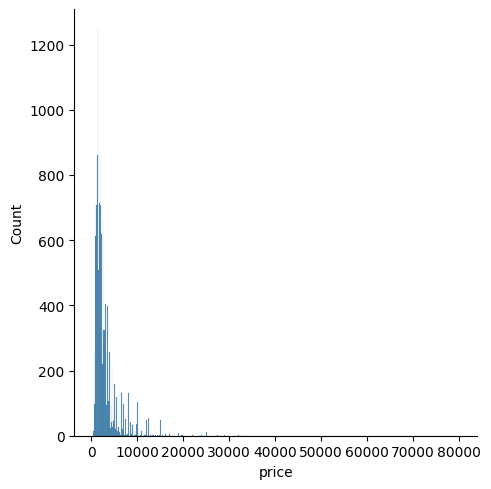

In [31]:
# variavael resposta normal
sns.displot( df4['price'] )

In [32]:
# função para remover outliers
def remove_outliers(df, coluna = None ,  keep_outliers = True ):
    
    if keep_outliers:
        print( 'Outliers mantidos' )
        return df
        
    else:
        # variavel resposta sem outliers
        df = remover_outliers( df4 , coluna )
        print('Outliers removidos')
        return df

In [33]:
# manter os outliers
df4 = remove_outliers( df4 )


Outliers mantidos


### 4.1.2 - Numerical Variable

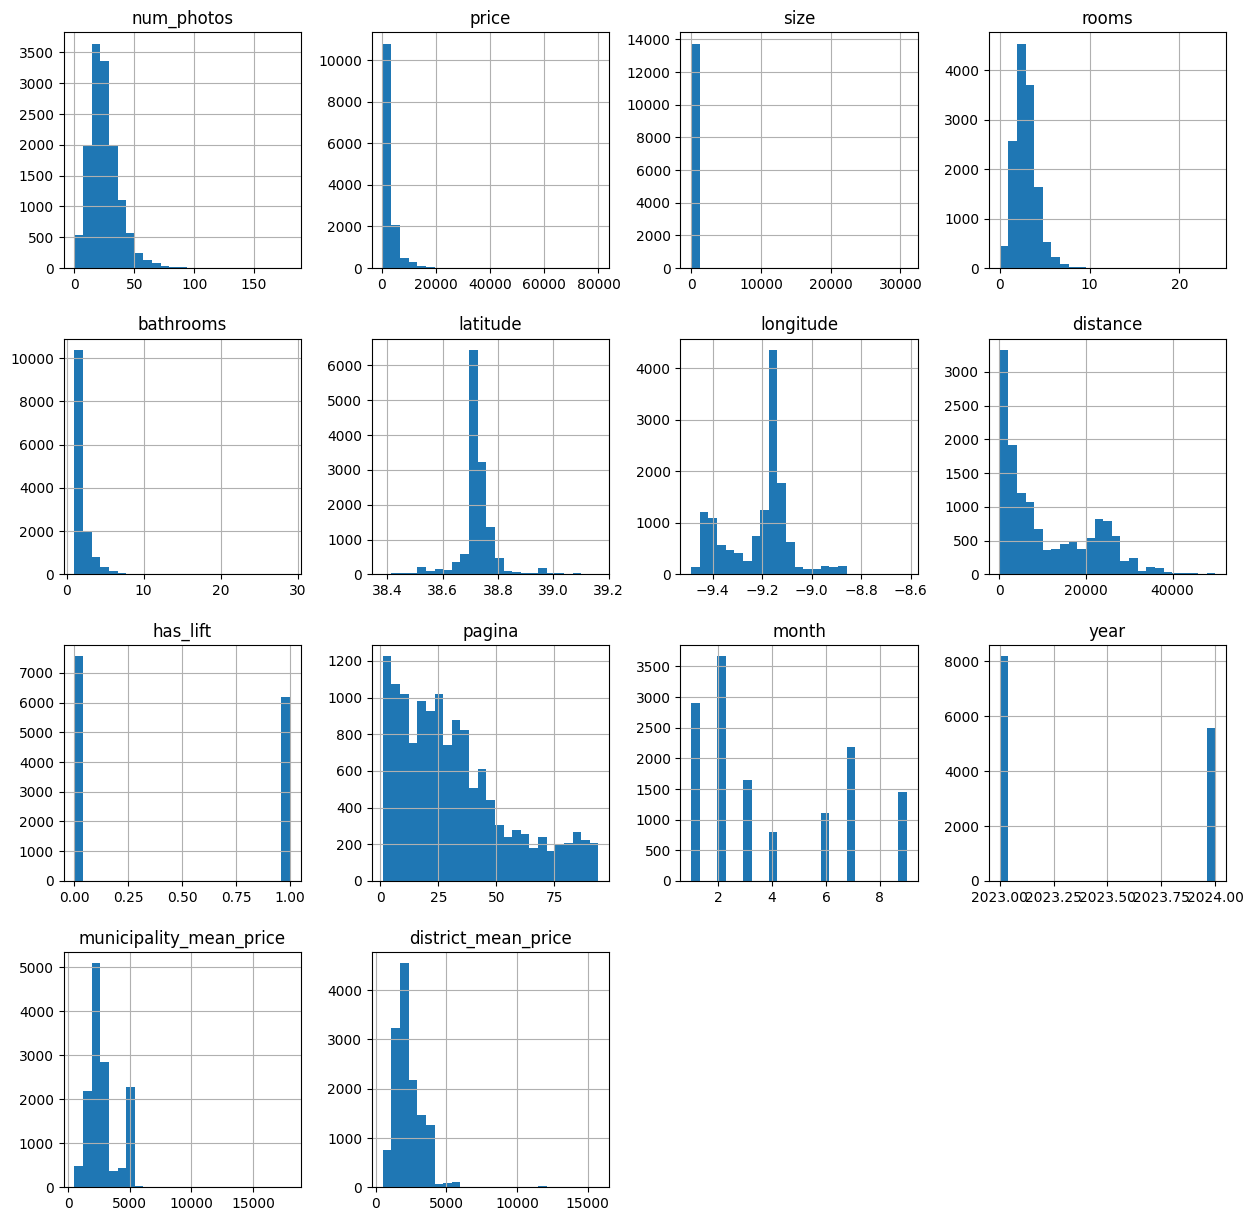

In [34]:
df4_num_attributes = df4.select_dtypes( include = ['int64','float64'] )
df4_num_attributes.hist( bins = 25, figsize=( 15,15 ) );

## 4.2. -  Análise Bivariada

### 4.2.1 - Correlação entre Atributos Numéricos

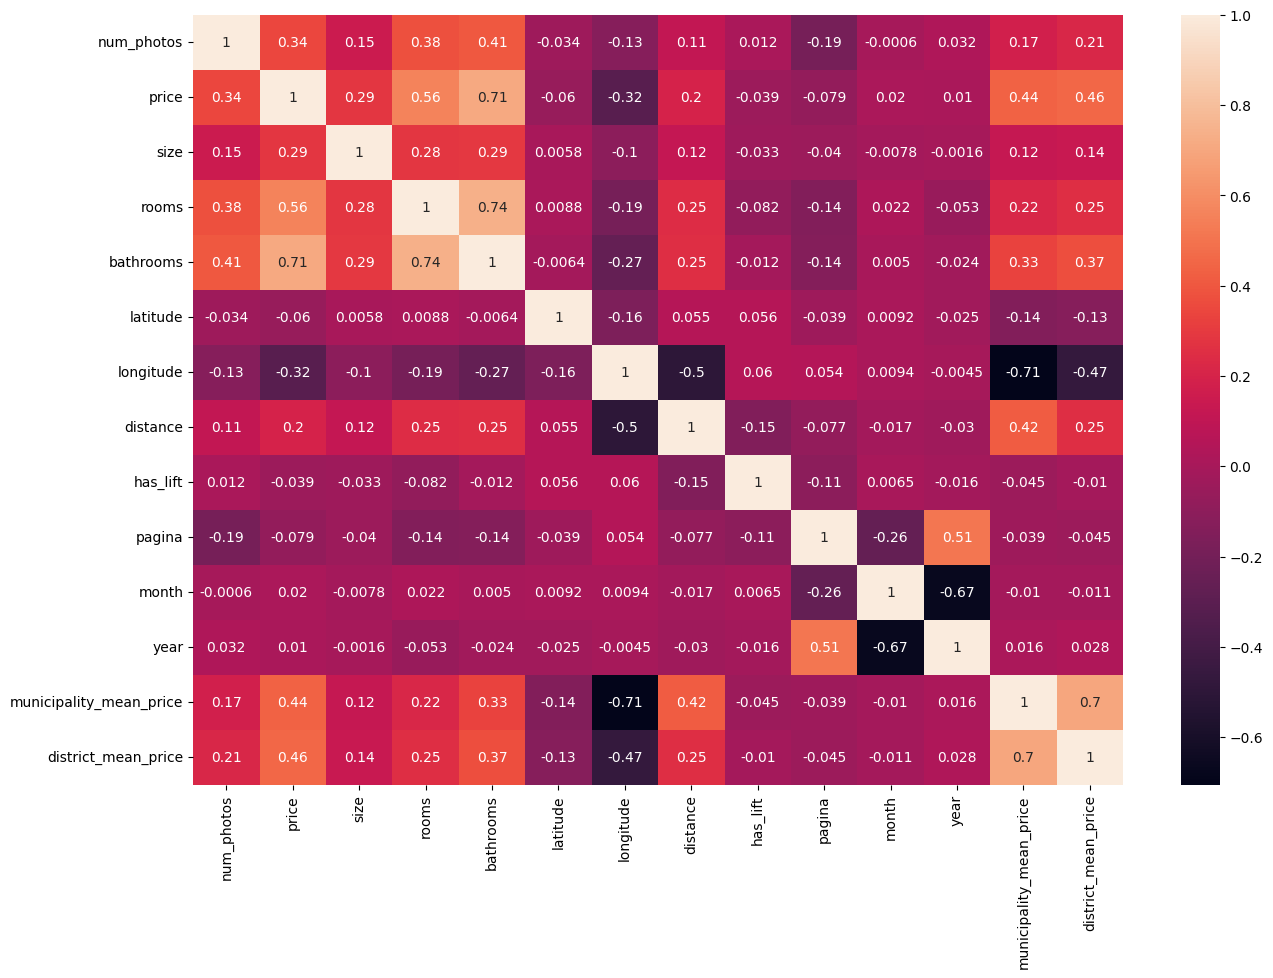

In [35]:
plt.figure( figsize = (15,10) )
correlation = df4_num_attributes.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

### 4.2.2 - Correlação entre Atributos Categóricos

In [36]:
a = df4.select_dtypes( include = ['object'] ) # pego o df mais atualizado

# aplico a função cramer v nas variáveis categoricas
a1 = cramer_v( a['floor'] , a['floor'] )
a2 = cramer_v( a['floor'], a['property_type'] )
a3 = cramer_v( a['floor'], a['address'] )
a4 = cramer_v( a['floor'], a['province'] )
a5 = cramer_v( a['floor'], a['municipality'] )
a6 = cramer_v( a['floor'], a['district'] )
a7 = cramer_v( a['floor'], a['description'] )
a8 = cramer_v( a['floor'], a['status'] )
a9 = cramer_v( a['floor'], a['detailed_type'] )
a10 = cramer_v( a['floor'], a['suggested_texts'] )
a11 = cramer_v( a['floor'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a12= cramer_v( a['property_type'], a['floor'] )
a13= cramer_v( a['property_type'], a['property_type'] )
a14= cramer_v( a['property_type'], a['address'] )
a15= cramer_v( a['property_type'], a['province'] )
a16= cramer_v( a['property_type'], a['municipality'] )
a17= cramer_v( a['property_type'], a['district'] )
a18= cramer_v( a['property_type'], a['description'] )
a19= cramer_v( a['property_type'], a['status'] )
a20= cramer_v( a['property_type'], a['detailed_type'] )
a21=cramer_v(  a['property_type'], a['suggested_texts'] )
a22=cramer_v(  a['property_type'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a23= cramer_v( a['address'], a['floor'] )
a24= cramer_v( a['address'], a['property_type'] )
a25= cramer_v( a['address'], a['address'] )
a26= cramer_v( a['address'], a['province'] )
a27= cramer_v( a['address'], a['municipality'] )
a28= cramer_v( a['address'], a['district'] )
a29= cramer_v( a['address'], a['description'] )
a30= cramer_v( a['address'], a['status'] )
a31= cramer_v( a['address'], a['detailed_type'] )
a32=cramer_v(  a['address'], a['suggested_texts'] )
a33=cramer_v(  a['address'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a34= cramer_v( a['province'], a['floor'] )
a35= cramer_v( a['province'], a['property_type'] )
a36= cramer_v( a['province'], a['address'] )
a37= cramer_v( a['province'], a['province'] )
a38= cramer_v( a['province'], a['municipality'] )
a39= cramer_v( a['province'], a['district'] )
a40= cramer_v( a['province'], a['description'] )
a41= cramer_v( a['province'], a['status'] )
a42= cramer_v( a['province'], a['detailed_type'] )
a43=cramer_v(  a['province'], a['suggested_texts'] )
a44=cramer_v(  a['province'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a45= cramer_v( a['municipality'], a['floor'] )
a46= cramer_v( a['municipality'], a['property_type'] )
a47= cramer_v( a['municipality'], a['address'] )
a48= cramer_v( a['municipality'], a['province'] )
a49= cramer_v( a['municipality'], a['municipality'] )
a50= cramer_v( a['municipality'], a['district'] )
a51= cramer_v( a['municipality'], a['description'] )
a52= cramer_v( a['municipality'], a['status'] )
a53= cramer_v( a['municipality'], a['detailed_type'] )
a54=cramer_v(  a['municipality'], a['suggested_texts'] )
a55=cramer_v(  a['municipality'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a56= cramer_v( a['district'], a['floor'] )
a57= cramer_v( a['district'], a['property_type'] )
a58= cramer_v( a['district'], a['address'] )
a59= cramer_v( a['district'], a['province'] )
a60= cramer_v( a['district'], a['municipality'] )
a61= cramer_v( a['district'], a['district'] )
a62= cramer_v( a['district'], a['description'] )
a63= cramer_v( a['district'], a['status'] )
a64= cramer_v( a['district'], a['detailed_type'] )
a65=cramer_v(  a['district'], a['suggested_texts'] )
a66=cramer_v(  a['district'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a67= cramer_v( a['description'], a['floor'] )
a68= cramer_v( a['description'], a['property_type'] )
a69= cramer_v( a['description'], a['address'] )
a70= cramer_v( a['description'], a['province'] )
a71= cramer_v( a['description'], a['municipality'] )
a72= cramer_v( a['description'], a['district'] )
a73= cramer_v( a['description'], a['description'] )
a74= cramer_v( a['description'], a['status'] )
a75= cramer_v( a['description'], a['detailed_type'] )
a76=cramer_v(  a['description'], a['suggested_texts'] )
a77=cramer_v(  a['description'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a78= cramer_v( a['status'], a['floor'] )
a79= cramer_v( a['status'], a['property_type'] )
a80= cramer_v( a['status'], a['address'] )
a81= cramer_v( a['status'], a['province'] )
a82= cramer_v( a['status'], a['municipality'] )
a83= cramer_v( a['status'], a['district'] )
a84= cramer_v( a['status'], a['description'] )
a85= cramer_v( a['status'], a['status'] )
a86= cramer_v( a['status'], a['detailed_type'] )
a87=cramer_v(  a['status'], a['suggested_texts'] )
a88=cramer_v(  a['status'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a89= cramer_v( a['detailed_type'], a['floor'] )
a90= cramer_v( a['detailed_type'], a['property_type'] )
a91= cramer_v( a['detailed_type'], a['address'] )
a92= cramer_v( a['detailed_type'], a['province'] )
a93= cramer_v( a['detailed_type'], a['municipality'] )
a94= cramer_v( a['detailed_type'], a['district'] )
a95= cramer_v( a['detailed_type'], a['description'] )
a96= cramer_v( a['detailed_type'], a['status'] )
a97= cramer_v( a['detailed_type'], a['detailed_type'] )
a98=cramer_v(  a['detailed_type'], a['suggested_texts'] )
a99=cramer_v(  a['detailed_type'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a100= cramer_v( a['suggested_texts'], a['floor'] )
a101= cramer_v( a['suggested_texts'], a['property_type'] )
a102= cramer_v( a['suggested_texts'], a['address'] )
a103= cramer_v( a['suggested_texts'], a['province'] )
a104= cramer_v( a['suggested_texts'], a['municipality'] )
a105= cramer_v( a['suggested_texts'], a['district'] )
a106= cramer_v( a['suggested_texts'], a['description'] )
a107= cramer_v( a['suggested_texts'], a['status'] )
a108= cramer_v( a['suggested_texts'], a['detailed_type'] )
a109=cramer_v(  a['suggested_texts'], a['suggested_texts'] )
a110=cramer_v(  a['suggested_texts'], a['parking_space'] )

# aplico a função cramer v nas variáveis categoricas
a111= cramer_v( a['parking_space'], a['floor'] )
a112= cramer_v( a['parking_space'], a['property_type'] )
a113= cramer_v( a['parking_space'], a['address'] )
a114= cramer_v( a['parking_space'], a['province'] )
a115= cramer_v( a['parking_space'], a['municipality'] )
a116= cramer_v( a['parking_space'], a['district'] )
a117= cramer_v( a['parking_space'], a['description'] )
a118= cramer_v( a['parking_space'], a['status'] )
a119= cramer_v( a['parking_space'], a['detailed_type'] )
a120=cramer_v(  a['parking_space'], a['suggested_texts'] )
a121=cramer_v(  a['parking_space'], a['parking_space'] )



d = pd.DataFrame( {'floor' : [a1,a2,a3,a4,a5,a6,a7,a8,a9,a10,a11],
                   'property_type' : [a12,a13,a14,a15,a16,a17,a18,a19,a20,a21,a22],
                   'address' : [a23,a24,a25,a26,a27,a28,a29,a30,a31,a32,a33],
                   'province' : [a34,a35,a36,a37,a38,a39,a40,a41,a42,a43,a44],
                   'municipality' : [a45,a46,a47,a48,a49,a50,a51,a52,a53,a54,a55],
                   'district' : [a56,a57,a58,a59,a60,a61,a62,a63,a64,a65,a66],
                   'description' : [a67,a68,a69,a70,a71,a72,a73,a74,a75,a76,a77],
                   'status' : [a78,a79,a80,a81,a82,a83,a84,a85,a86,a87,a88],
                   'detailed_type' : [a89,a90,a91,a92,a93,a94,a95,a96,a97,a98,a99],
                   'suggested_texts' : [a100,a101,a102,a103,a104,a105,a106,a107,a108,a109,a110],
                   'parking_space' : [a111,a112,a113,a114,a115,a116,a117,a118,a119,a120,a121]
              
              } )

d = d.set_index( d.columns )
d = d.drop( 'province', axis = 1 )

C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\3203194230.py:112: RuntimeWarning: invalid value encountered in sqrt
  v = np.sqrt( ( chi2corr/n ) / ( min ( kcorr-1 , rcorr-1 ) )  )
C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\3203194230.py:112: RuntimeWarning: i

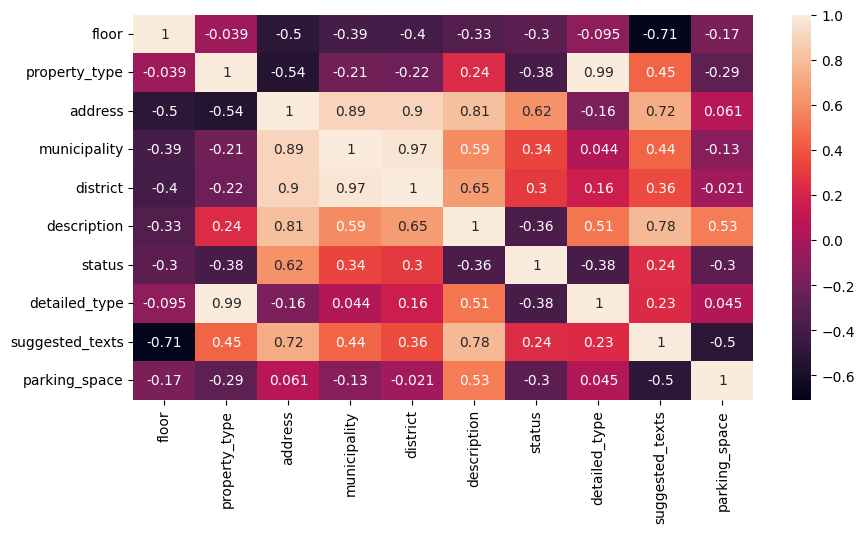

In [37]:
plt.figure(figsize=(10,5))
correlation = d.corr( method = 'pearson' )
sns.heatmap( correlation, annot = True );

# Data Preparation

In [38]:
# dividir entre treino e teste
X = df4.drop( 'price', axis = 1 )
y = df4['price']

X_train_n, X_test_n , y_train_n , y_test_n = train_test_split(X, y, test_size=0.2, random_state=39)

print('Total Shape {}'.format( df4.shape ))

print('X_train shape {}'.format(X_train_n.shape) )
print('y_train shape {}'.format(y_train_n.shape) )

print('=='*50)

print('X_test shape {}'.format(X_test_n.shape) )
print('y_test shape {}'.format(y_test_n.shape) )

Total Shape (13755, 34)
X_train shape (11004, 33)
y_train shape (11004,)
X_test shape (2751, 33)
y_test shape (2751,)


In [39]:
# df treino
df_treino = pd.concat( [X_train_n,y_train_n ], axis = 1 )

In [144]:
# df teste
df_teste = pd.concat( [X_test_n,y_test_n] , axis = 1)

In [41]:
df5 = df_treino.copy()

In [42]:
stats( df5 )

,features,min,max,range,mean,median,std,skew,kurtosis
0,num_photos,0.00,180.00,180.00,24.91,23.00,13.03,1.60,6.15
1,size,10.00,"3,500.00","3,490.00",137.77,107.00,116.73,6.33,109.85
2,rooms,0.00,24.00,24.00,2.49,2.00,1.38,1.80,14.76
3,bathrooms,1.00,29.00,28.00,2.02,2.00,1.24,2.75,26.93
4,latitude,38.38,39.16,0.78,38.73,38.72,0.07,0.95,8.40
5,longitude,-9.49,-8.62,0.87,-9.21,-9.16,0.13,-0.18,0.00
6,distance,61.00,"49,855.00","49,794.00","11,035.39","6,620.00","10,292.77",0.86,-0.30
7,has_lift,0.00,1.00,1.00,0.45,0.00,0.50,0.19,-1.96
8,pagina,1.00,94.00,93.00,31.82,27.00,23.60,0.85,-0.06
9,month,1.00,9.00,8.00,3.89,3.00,2.73,0.63,-1.08


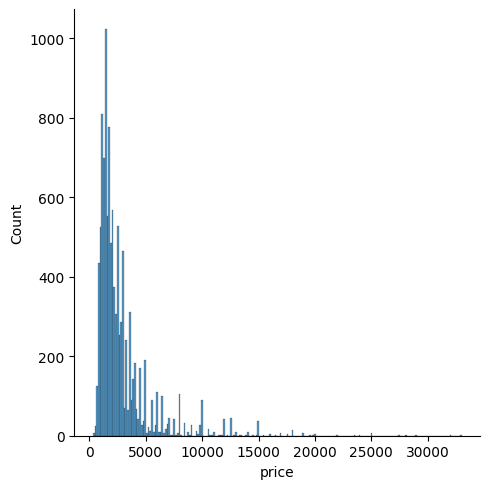

In [43]:
sns.displot( df5['price'] )

## 5.1. - Rescaling

## 5.1.2 Check Distribution

C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\4291806037.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['num_photos']  )


Text(0.5, 1.0, 'num_photos')

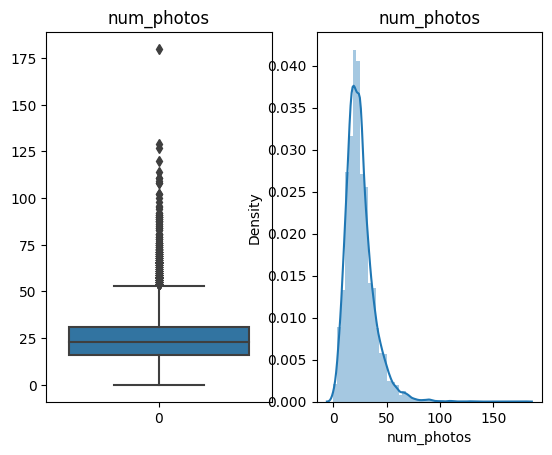

In [44]:
plt.subplot(1, 2, 1)
# num_photos
sns.boxplot( df5['num_photos'] )
plt.title( 'num_photos' )

plt.subplot(1, 2, 2)
# num_photos
sns.distplot( df5['num_photos']  )
plt.title( 'num_photos' )

C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\466936489.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['size']  )


Text(0.5, 1.0, 'size')

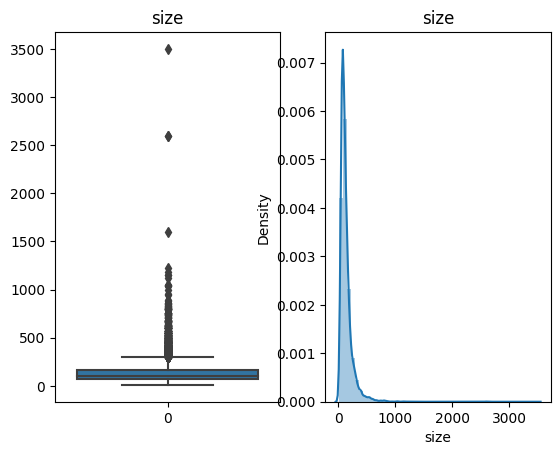

In [45]:
plt.subplot(1, 2, 1)
# size
sns.boxplot( df5['size'] )
plt.title( 'size' )

plt.subplot(1, 2, 2)
# size
sns.distplot( df5['size']  )
plt.title( 'size' )

C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\852878364.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['rooms']  )


Text(0.5, 1.0, 'rooms')

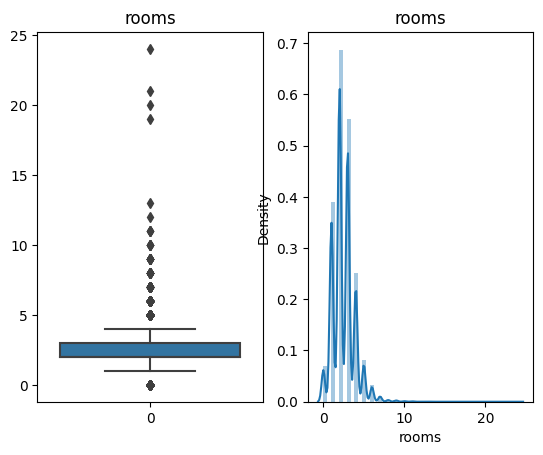

In [46]:
plt.subplot(1, 2, 1)
# rooms
sns.boxplot( df5['rooms'] )
plt.title( 'rooms' )

plt.subplot(1, 2, 2)
# rooms
sns.distplot( df5['rooms']  )
plt.title( 'rooms' )


C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\3003154550.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['bathrooms']  )


Text(0.5, 1.0, 'bathrooms')

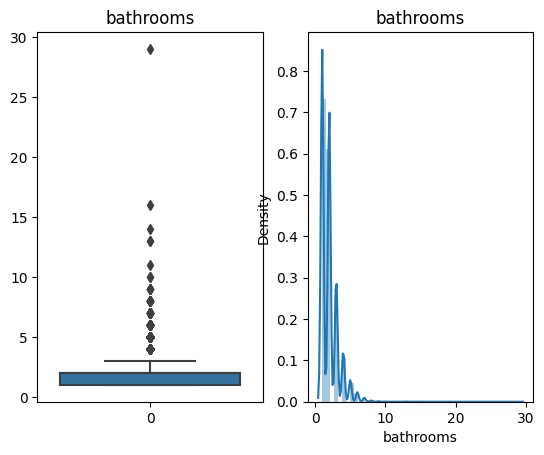

In [47]:
plt.subplot(1, 2, 1)
# bathrooms
sns.boxplot( df5['bathrooms'] )
plt.title( 'bathrooms' )

plt.subplot(1, 2, 2)
# rooms
sns.distplot( df5['bathrooms']  )
plt.title( 'bathrooms' )

C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\3748452618.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot( df5['distance']  )


Text(0.5, 1.0, 'distance')

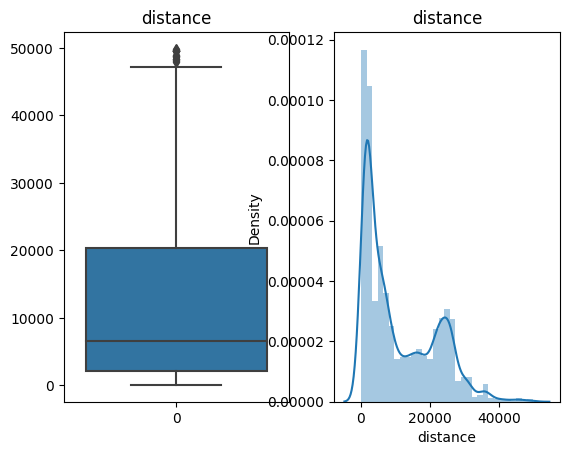

In [48]:
plt.subplot(1, 2, 1)
# distance
sns.boxplot( df5['distance'] )
plt.title( 'distance' )

plt.subplot(1, 2, 2)
# rooms
sns.distplot( df5['distance']  )
plt.title( 'distance' )

In [49]:
def rescaling_data(df, rescale = False ):
    
    if rescale:
        rs = RobustScaler() # robusto com outliers
        mms = pp.MinMaxScaler() # desvio padrão pequeno e quando não ha distribuição gaussiana
        
#         # num_photos
#         rs_num_photos = RobustScaler() 
#         # num_photos
#         df['num_photos'] = rs_num_photos.fit_transform( df[['num_photos']].values )

        # floor
#         rs_floor = RobustScaler() 
#         # num_photos
#         df['floor'] = rs_floor.fit_transform( df[['floor']].values )
        
        # size
        rs_size = RobustScaler() 
        # size
        df['size'] = rs_size.fit_transform( df[['size']].values )
        
        # rooms
#         mms_rooms = pp.MinMaxScaler() 
#         # rooms
#         df['rooms'] = mms_rooms.fit_transform( df[['rooms']].values )
        
        # bathrooms
#         rs_bathrooms = RobustScaler() 
#         # bathrooms
#         df['bathrooms'] = rs_bathrooms.fit_transform( df[['bathrooms']].values )
        
        # distance
        rs_distance = RobustScaler()
        # distance
        df['distance'] = rs_distance.fit_transform( df[['distance']].values )
        
        
        
        print('Rescaled')
        
        return  df
    else:
        print('Not rescaled')
        
        return df

In [50]:
df5 = rescaling_data( df5, rescale = True  )

Rescaled


In [51]:
df5.status.unique()

array(['good', 'newdevelopment', 'renew'], dtype=object)

In [52]:
df5.isna().sum()

thumbnail                  0
num_photos                 0
floor                      0
property_type              0
size                       0
rooms                      0
bathrooms                  0
address                    0
province                   0
municipality               0
district                   0
latitude                   0
longitude                  0
show_address               0
distance                   0
description                0
has_video                  0
status                     0
new_development            0
has_lift                   0
detailed_type              0
suggested_texts            0
has_plan                   0
has3_d_tour                0
has360                     0
has_staging                0
top_new_development        0
parking_space              0
pagina                     0
month                      0
year                       0
municipality_mean_price    0
district_mean_price        0
price                      0
dtype: int64

## 5.2 Encoding 

In [53]:
def encoding( df ):
    
    # floor - substituo os andares com letras
    df['floor'] = df['floor'].replace( ['bj','st','ss','en'], 0 )
    # transformo em inteiros
    df['floor'] = df['floor'].astype( 'int64' )

    #property_type - label
    te_property_type = {'flat' : 0, 'duplex' : 1, 'chalet' : 2, 'studio': 3, 'penthouse': 4, 'countryHouse':5}
    #te_property_type = df.groupby( 'property_type' )['price'].mean()
    df['property_type'] = df['property_type'].map( te_property_type )
    pickle.dump(te_property_type,open(r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_property_type.pkl', 'wb' ) )
    
    # address - label
    freq_encoding_address = df['address'].value_counts(normalize=True)
    df['address'] = df['address'].map( freq_encoding_address )
    pickle.dump( freq_encoding_address, open(r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\freq_encoding_address.pkl', 'wb') )
                
    # province 
    te_province = df['province'].value_counts( )
    #te_province = df.groupby( 'province' )['price'].mean()
    df['province'] = df['province'].map( te_province )
    pickle.dump( te_province, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_province.pkl', 'wb' ) )
                
    # municipality - label
    te_municipality = df['municipality'].value_counts()
    #te_municipality = df.groupby( 'municipality' )['price'].mean()
    df['municipality'] = df['municipality'].map( te_municipality ).astype( 'float64' )
    pickle.dump( te_municipality, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_municipality.pkl', 'wb' ) )            
    
    # municipality
#     freq_encoding_municipality = df['municipality'].value_counts(normalize=True)
#     df['municipality'] = df['municipality'].map( freq_encoding_municipality )
    

    # district - label
    te_district = df['district'].value_counts()
    #te_district = df.groupby( 'district' )['price'].mean()
    df['district'] = df['district'].map( te_district ).astype( 'float64' )
    pickle.dump( te_district, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_district.pkl', 'wb' ) )  
    # district
#     freq_encoding_district = df['district'].value_counts(normalize=True)
#     df['district'] = df['district'].map( freq_encoding_district )
    
    
    # Show address
    encoding = {True: 1 , False: 0}
    df['show_address'] = df['show_address'].apply( lambda x : 1 if x == True else 0 )

    # description
    df['description'] = df['description'].apply( lambda x : len(x) )

    # has_video
    encoding = {True: 1 , False: 0}
    df['has_video'] = df['has_video'].map( encoding )

    # status
    te_status = {'good' : 1, 'newdevelopment' : 2 , 'renew' : 3}
    #te_status = df.groupby( 'status' )['price'].mean()
    df['status'] = df['status'].map( te_status ).astype( 'float64' )
    pickle.dump( te_status, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_status.pkl', 'wb' ) )  
    
    # label encoder status
    #status_encoder = LabelEncoder()
    #df['status'] = status_encoder.fit_transform( df['status'] )
    
    # new_development
    encoding = {True: 1 , False: 0}
    df['new_development'] = df['new_development'].map( encoding )

    # detailed type - label
    le_detailed_type = LabelEncoder()
    
    df['detailed_type'] = df['detailed_type'].apply(lambda x: ast.literal_eval(x) )
    df['detailed_type'] = df['detailed_type'].apply(lambda x: x['typology'] )
    df['detailed_type'] = le_detailed_type.fit_transform( df['detailed_type'] )
    pickle.dump( le_detailed_type, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\le_detailed_type.pkl', 'wb' ) ) 

    # suggested text
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : ast.literal_eval(x) )
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : x['title'] )
    df['suggested_texts'] = df['suggested_texts'].apply( lambda x : len(x) )

    # hasplan
    encoding = {True: 1 , False: 0}
    df['has_plan'] = df['has_plan'].map( encoding )

    # has3_d_tour
    encoding = {True: 1 , False: 0}
    df['has3_d_tour'] = df['has3_d_tour'].map( encoding )

    # has360
    encoding = {True: 1 , False: 0}
    df['has360'] = df['has360'].map( encoding )

    # has_staging
    df['has_staging'] = df['has_staging'].apply( lambda x: 1 if x   else 0   )

    # top_new_development
    df['top_new_development'] = df['top_new_development'].apply( lambda x: 1 if x  else 0 )
    
    #parking_space
    encoding = {True: 1 , False: 0}
    df['parking_space'] = df['parking_space'].apply(lambda x: ast.literal_eval(x) if x != 0 else x ) 
    df['parking_space'] = df['parking_space'].apply(lambda x: x['hasParkingSpace'] if x != 0 else x ) 
    df['parking_space'] = df['parking_space'].map( encoding )

    
    return df

In [54]:
df5 = encoding( df5 )


In [55]:
df5.province.unique()

array([9897, 1096,   11], dtype=int64)

# 6.0 Feature Selection

In [56]:
df6 = df5.copy()

## 6.1 Boruta

In [100]:
def boruta_selection(df , use_boruta = False):
    
    if use_boruta:
    
        # training and test dataset for boruta
        X_train = df6.drop( ['price'] , axis= 1 ).values
        y_train = df6['price'].values.ravel()

        # instancia do Rf
        rf = RandomForestRegressor( n_jobs = -1 )

        # aplico o boruta
        boruta = BorutaPy( rf, n_estimators = 'auto', verbose = 2, random_state = 42 ).fit( X_train, y_train )
        
        # pega as colunas e coloca na variavel
        cols_selected = boruta.support_.tolist()

        # df boruta
        df_boruta = df6.drop('price', axis = 1).loc[ : , cols_selected]

        X_train = df6.drop( ['price'] , axis= 1 )
        cols_selected_boruta = X_train.loc[ : , cols_selected ]

        # cols not selected boruta
        cols_not_selected = list( np.setdiff1d( X_train.columns, cols_selected_boruta.columns ) )
        
        print('Boruta Used')
        
        return cols_selected_boruta, cols_not_selected
    
    else:
        print('Boruta skipped')
        return df

        


In [101]:
df6, cols_not_sel = boruta_selection(df6, use_boruta = True)

Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	33
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	22
Iteration: 	9 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	22
Iteration: 	10 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	22
Iteration: 	11 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	22
Iteration: 	12 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	22
Iteration: 	13 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	22
Iteration: 	14 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	22
Iteration: 	15 / 100
Confirmed: 	10
Tentative: 	1
Rejected: 	22
Iteration: 	16 / 100
Confirmed: 	10
Tentative: 	1
Reject

In [112]:
df6 = df5[['size', 'bathrooms', 'address', 'municipality', 'latitude', 'longitude',
       'distance', 'description', 'municipality_mean_price',
       'district_mean_price','price']]

# 7.0 Machine Learning

In [113]:
# columns used for training
colunas_treino_modelo = df6.columns.to_list()

In [136]:
df7 = df6.copy()

## 7.1 - Divisão entre treino e teste

In [137]:
# treino
X_train = df7.drop( 'price', axis = 1 )
y_train = df7['price']

In [123]:
# df_teste = df_teste[['size', 'bathrooms', 'address', 'municipality', 'latitude', 'longitude',
#        'distance', 'description', 'municipality_mean_price',
#        'district_mean_price','price']]

In [145]:
# tratando os dados teste
idealista = Idealista()

df_teste_0 = idealista.rescaling_data( df_teste , rescale = True )
df_teste_1 = idealista.encoding( df_teste_0 )


Rescaled


In [146]:
# separando os dados de teste
X_test = df_teste_1.drop('price', axis = 1 )
y_test = df_teste_1['price']

## 7.2 - Linear Regression

In [148]:
cols = ['size', 'bathrooms', 'address', 'municipality', 'latitude', 'longitude',
       'distance', 'description', 'municipality_mean_price',
       'district_mean_price']

In [149]:
# Criar um modelo de regressão linear
lr = LinearRegression()

# Treinar o modelo
lr.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred = lr.predict(X_test[cols])


In [150]:
lr_metrics = ml_error( 'Linear Regression', y_test   , y_pred )
lr_metrics

,Model Name,MAE,MAPE,RMSE,R2_score
0,Linear Regression,986.81,0.34,"5,869.74",-3.12


## 7.2.1 - Linear Regression Cross Validation

In [66]:
# cross validation
precision_scores = cross_val_score(lr, X_train, y_train, cv=100, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
cv_lr = np.round(mean_score,2)
lr_metrics_cv = pd.concat( [lr_metrics, pd.DataFrame( {'Cv Score' : [cv_lr]} ) ], axis = 1)
lr_metrics_cv

,Model Name,MAE,MAPE,RMSE,R2_score,Cv Score
0,Linear Regression,988.78,0.35,"5,766.13",-2.97,0.66


## 7.3 Lassso

In [151]:
# model
lrr = Lasso( alpha = 0.01 ).fit( X_train , y_train )

# prediction
y_hat_lrr = lrr.predict( X_test[cols] )

# performance
lrr_result = ml_error( 'Lasso',  y_test  ,  y_hat_lrr  )
lrr_result

,Model Name,MAE,MAPE,RMSE,R2_score
0,Lasso,986.74,0.34,"5,869.70",-3.12


## 7.3.1 - Lasso Cross Validation

In [68]:
# cross validation
precision_scores = cross_val_score(lrr, X_train, y_train, cv=20, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
cv_lasso = np.round( mean_score, 2)
lrr_result_cv = pd.concat( [lrr_result, pd.DataFrame( {'Cv Score' : [cv_lasso]} ) ], axis = 1) 
lrr_result_cv

,Model Name,MAE,MAPE,RMSE,R2_score,Cv Score
0,Lasso,988.70,0.35,"5,766.36",-2.98,0.66


## 7.4 Random Forest

In [152]:
# model
rf = RandomForestRegressor( n_estimators = 100 , n_jobs = -1, random_state = 42  )

rf.fit( X_train , y_train )

# prediction
y_hat_rf = rf.predict(  X_test[cols] )

# 
rf_result = ml_error( 'Random Forest Regressor',  y_test  ,  y_hat_rf  )
rf_result

,Model Name,MAE,MAPE,RMSE,R2_score
0,Random Forest Regressor,673.63,0.21,"1,871.15",0.58


## 7.4 Random Forest Cross Validation

In [70]:
# cross validation
precision_scores = cross_val_score(rf, X_train, y_train, cv=5, scoring= 'r2')

# mean score 
mean_score = np.mean( precision_scores )
rf_cv = np.round( mean_score, 2)
rf_result_cv = pd.concat( [rf_result, pd.DataFrame( {'Cv Score' : [rf_cv]} ) ], axis = 1) 
rf_result_cv

,Model Name,MAE,MAPE,RMSE,R2_score,Cv Score
0,Random Forest Regressor,636.44,0.21,"1,841.76",0.59,0.76


## 7.5 LGBM

In [154]:
# Criar um conjunto de dados LightGBM a partir dos dados de treinamento
train_data = lgb.Dataset(X_train, label=y_train)

# Definir parâmetros básicos
params = {
    'objective': 'regression',  # Regressão
    'metric': 'l2',  # Métrica de avaliação (erro quadrático médio)
    'boosting_type': 'gbdt',  # Tipo de aumento (gradient boosting)
}

# Treinar o modelo LightGBM
num_round = 100  # Número de iterações (árvores) de treinamento
bst = lgb.train(params, train_data, num_boost_round=num_round)

# Fazer previsões no conjunto de teste
y_pred_lgbm = bst.predict( X_test[cols] )

# performance
lgbm = ml_error( 'lgbm',  y_test  ,  y_pred_lgbm  )
lgbm


[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000851 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1686
[LightGBM] [Info] Number of data points in the train set: 11004, number of used features: 10
[LightGBM] [Info] Start training from score 2805.586787


,Model Name,MAE,MAPE,RMSE,R2_score
0,lgbm,675.26,0.21,"1,892.68",0.57


## 7.5.1 LGBM Cross Validation

In [72]:
# Definir parâmetros básicos
params = {
    'objective': 'regression',  # Regressão
    'metric': 'r2',  # Usando R² como métrica de avaliação, se suportado pela sua versão do LightGBM
    'boosting_type': 'gbdt',  # Tipo de aumento (gradient boosting)
}

# Preparar o conjunto de dados LightGBM
lgb_data = lgb.Dataset(X_train, label=y_train)

# Número de iterações de treinamento
num_round = 100

# Configuração da validação cruzada
nfold = 10
seed = 42

kf = KFold(n_splits=nfold, random_state=seed, shuffle=True)

r2_scores = []

# Realizar a validação cruzada
for train_idx, val_idx in kf.split(X_train):
    X_train_fold = X_train.iloc[train_idx]  # Seleciona as linhas de treinamento
    y_train_fold = y_train.iloc[train_idx]  # Seleciona os rótulos de treinamento
    X_val_fold = X_train.iloc[val_idx]  # Seleciona as linhas de validação

    # Treinar o modelo LightGBM
    bst = lgb.train(params, lgb.Dataset(X_train_fold, label=y_train_fold), num_boost_round=num_round)

    # Fazer previsões no conjunto de validação
    y_pred = bst.predict(X_val_fold)

    # Calcular o R² score
    r2 = r2_score(y_train.iloc[val_idx], y_pred)
    r2_scores.append(r2)

# Mostrar a média dos R² scores
mean_r2 = np.mean(r2_scores)
lgbm_cv = pd.concat( [lgbm, pd.DataFrame( {'Cv Score' : [mean_r2]} ) ], axis = 1) 
lgbm_cv

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001392 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2093
[LightGBM] [Info] Number of data points in the train set: 9903, number of used features: 30
[LightGBM] [Info] Start training from score 2805.127133
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001262 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2088
[LightGBM] [Info] Number of data points in the train set: 9903, number of used features: 30
[LightGBM] [Info] Start training from score 2805.174796
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002315 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

,Model Name,MAE,MAPE,RMSE,R2_score,Cv Score
0,lgbm,645.45,0.21,"1,853.31",0.59,0.77


## 7.6 XGBOOST

In [155]:
# Criar um modelo XGBoost Regressor
model_xgb = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3, learning_rate=0.1)

# Treinar o modelo
model_xgb.fit(X_train, y_train)

# Fazer previsões no conjunto de teste
y_pred_xgb = model_xgb.predict( X_test[cols])

# performance
xgb_performance = ml_error( 'xgb',  y_test  ,  y_pred_xgb  )
xgb_performance

,Model Name,MAE,MAPE,RMSE,R2_score
0,xgb,722.45,0.23,"1,912.80",0.56


## 7.6.1 XGBOOST Cross Validation

In [74]:
# Realizar validação cruzada com 5 folds (ou o número que preferir) usando o R2 como métrica
scores = cross_val_score(model_xgb, X_train, y_train, cv=5, scoring='r2')

# Calcular a média dos coeficientes R2
mean_r2 = scores.mean()

# Imprimir o R2 médio
result_xgb = pd.concat( [xgb_performance, pd.DataFrame( {'Cv Score' : [mean_r2]} ) ], axis = 1) 

## 7.7 Resultados Modelos

In [156]:
pd.concat( [lr_metrics_cv, lrr_result_cv, rf_result_cv , lgbm_cv , result_xgb] , axis = 0 ).sort_values( by = 'MAE'
 , ascending = True)

,Model Name,MAE,MAPE,RMSE,R2_score,Cv Score
0,Random Forest Regressor,636.44,0.21,"1,841.76",0.59,0.76
0,lgbm,645.45,0.21,"1,853.31",0.59,0.77
0,xgb,684.96,0.22,"1,868.71",0.58,0.74
0,Lasso,988.70,0.35,"5,766.36",-2.98,0.66
0,Linear Regression,988.78,0.35,"5,766.13",-2.97,0.66


## 7.8 Resultados Cross Validation

## 8.1 Criando a classe Idealista

In [87]:
class Idealista:
    def __init__( self ):
        
        self.df_region = pd.read_csv( 'datasets/df_region.csv' )
        self.home_path                    = r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings'

        self.te_status                    = pickle.load(open(os.path.join(self.home_path, 'te_status.pkl'), 'rb'))
        self.te_province                  = pickle.load(open(os.path.join(self.home_path,'te_province.pkl') , 'rb'))
        self.te_property_type             = pickle.load(open(os.path.join(self.home_path,'te_property_type.pkl'), 'rb'))
        self.te_municipality              = pickle.load(open(os.path.join(self.home_path,'te_municipality.pkl'), 'rb' ))
        self.te_district                  = pickle.load(open(os.path.join(self.home_path,'te_district.pkl'),'rb'))
        self.le_detailed_type             = pickle.load(open(os.path.join(self.home_path,'le_detailed_type.pkl'),'rb' ))
        self.freq_encoding_address        = pickle.load(open(os.path.join(self.home_path,'freq_encoding_address.pkl'), 'rb' ))
        
    def transform_data(self, df, colunas_irrelevantes ):

        cols_old = df.columns.to_list()

        # def função snake_case
        snake_case = lambda x: inflection.underscore( x )

        # defino as novas colunas
        cols_new = list(map( snake_case, cols_old )) 

        # atribuo as novas colunas ao df
        df.columns = cols_new

        # removo as linhas em branco que possam ter vindo na extração
        df = df.loc[~ df['property_code'].isna() , : ]

        # removo duplicadas
        df = df.drop_duplicates( subset= ['property_code'], keep = 'last' )

        # preencho os vazios
        df = fill_na( df )

        # deleto as colunaas irrelevantes
        df = delete_columns( df , colunas_irrelevantes )
   
        return df


#=======================================================================================================================#

    def feature_engineering(self, df , transform_data = False, merge_datasets = False   ):
        
        if transform_data == True and merge_datasets == False :
            
            # mes
            df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
            df['month'] = df['datetime_scrapy'].dt.month 

            # ano
            df['year'] = df['datetime_scrapy'].dt.year

            # excluir a coluna datetime
            df = df.drop( 'datetime_scrapy', axis = 1 )

            print( 'Dados Transformados' )

            return df
        
    
        if merge_datasets == True and transform_data == False:
        
            # Df com a média de preço por município
            df_municipality_mean_price = self.df_region.groupby('municipality')[['price']].median().reset_index()

            # alteração nome coluna
            df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

            # exportar para csv
            #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

#======================================================================================================================#

#             # calculando a média por 'province'
#             df2_province_mean_price = self.df_region.groupby( 'province' )[['price']].median().reset_index().rename( columns = { 'price': 'province_mean_price' } )

#             # exportando para csv
#             # df2_province_mean_price.to_csv( 'datasets/province.csv' )

#             # acrescentando a coluna ao df2
#             df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

    #=======================================================================================================================#

            # calculando média por district
            df2_district_mean_price = self.df_region.groupby( 'district' )[['price']].median().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

            # exportando para csv 
            #df2_district_mean_price.to_csv( 'datasets/district.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

            print( 'Datasets combinados com preços regioes' )

            return df
    
        if transform_data == True and merge_datasets == True:

            # mes
            df['datetime_scrapy'] = pd.to_datetime( df['datetime_scrapy'] )
            df['month'] = df['datetime_scrapy'].dt.month 

            # ano
            df['year'] = df['datetime_scrapy'].dt.year

            # excluir a coluna datetime
            df = df.drop( 'datetime_scrapy', axis = 1 )

            # Df com a média de preço por município
            df_municipality_mean_price = self.df_region.groupby('municipality')[['price']].mean().reset_index()

            # alteração nome coluna
            df_municipality_mean_price = df_municipality_mean_price.rename(columns={'price': 'municipality_mean_price'})

            # exportar para csv
            #d f2_municipality_mean_price.to_csv( 'datasets/municipality.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df, df_municipality_mean_price, on = 'municipality' , how = 'left' )

    # ======================================================================================================================#

#             # calculando a média por 'province'
#             df2_province_mean_price = self.df_region.groupby( 'province' )[['price']].mean().reset_index().rename( columns = { 'price': 'province_mean_price' } )

#             # exportando para csv
#             # df2_province_mean_price.to_csv( 'datasets/province.csv' )

#             # acrescentando a coluna ao df2
#             df = pd.merge( df, df2_province_mean_price , on = 'province' , how = 'left' )

    #=======================================================================================================================#

            # calculando média por district
            df2_district_mean_price = self.df_region.groupby( 'district' )[['price']].mean().reset_index().rename( columns = { 'price' : 'district_mean_price' } )

            # exportando para csv 
            #df2_district_mean_price.to_csv( 'datasets/district.csv' )

            # acrescentando a coluna ao df2
            df = pd.merge( df , df2_district_mean_price , on = 'district', how = 'left' )

            print( 'datasets combinados e dados transformados' )
        
            return df
        
        else:

            print( 'Nenhuma Transformação' )

            return df
            
#=======================================================================================================================#
    
    def filter_variables(self, df, filter_variables = False):
    
        if filter_variables:

            # Vou querer saber somente os preços na province de Lisboa
            df = df.loc[ df['province'] == 'Lisboa' , :  ]

            # vou querer somente as habitações que tenham de 0 a no máximo 4 quartos
            df = df.loc[ df['rooms'].isin( [ 0,1,2,3,4 ] ) , : ]

            print('Variavies filtradas')

            return df

        else:

            print('Variavies não filtradas')

            return df

#=======================================================================================================================#

    # função para remover outliers
    def remove_outliers(self, df, coluna = None ,  keep_outliers = True ):

        if keep_outliers:
            print( 'Outliers mantidos' )
            return df

        else:
            # variavel resposta sem outliers
            df = remover_outliers( df4 , coluna )
            print('Outliers removidos')
            return df

#=======================================================================================================================#
    
    def rescaling_data(self, df, rescale = False ):

        if rescale:
            rs = RobustScaler() # robusto com outliers
            mms = pp.MinMaxScaler() # desvio padrão pequeno e quando não ha distribuição gaussiana

    #         # num_photos
    #         rs_num_photos = RobustScaler() 
    #         # num_photos
    #         df['num_photos'] = rs_num_photos.fit_transform( df[['num_photos']].values )

            # floor
#             rs_floor = RobustScaler() 
#             # num_photos
#             df['floor'] = rs_floor.fit_transform( df[['floor']].values )

            # size
            rs_size = RobustScaler() 
            # size
            df['size'] = rs_size.fit_transform( df[['size']].values )

            # rooms
    #         mms_rooms = pp.MinMaxScaler() 
    #         # rooms
    #         df['rooms'] = mms_rooms.fit_transform( df[['rooms']].values )

            # bathrooms
    #         rs_bathrooms = RobustScaler() 
    #         # bathrooms
    #         df['bathrooms'] = rs_bathrooms.fit_transform( df[['bathrooms']].values )

            # distance
            rs_distance = RobustScaler()
            # distance
            df['distance'] = rs_distance.fit_transform( df[['distance']].values )



            print('Rescaled')

            return  df
        else:
            print('Not rescaled')

            return df

#=======================================================================================================================#

    def encoding( self, df ):

        # floor - substituo os andares com letras
        df['floor'] = df['floor'].replace( ['bj','st','ss','en'], 0 )
        # transformo em inteiros
        df['floor'] = df['floor'].astype( 'int64' )

        #property_type - label
        te_property_type = {'flat' : 0, 'duplex' : 1, 'chalet' : 2, 'studio': 3, 'penthouse': 4, 'countryHouse':5}
        #te_property_type = df.groupby( 'property_type' )['price'].mean()
        df['property_type'] = df['property_type'].map( te_property_type )
        pickle.dump(te_property_type,open(r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_property_type.pkl', 'wb' ) )

        # address - label
        freq_encoding_address = df['address'].value_counts(normalize=True)
        df['address'] = df['address'].map( freq_encoding_address )
        pickle.dump( freq_encoding_address, open(r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\freq_encoding_address.pkl', 'wb') )

        # province 
        te_province = df['province'].value_counts( )
        #te_province = df.groupby( 'province' )['price'].mean()
        df['province'] = df['province'].map( te_province )
        pickle.dump( te_province, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_province.pkl', 'wb' ) )

        # municipality - label
        te_municipality = df['municipality'].value_counts()
        #te_municipality = df.groupby( 'municipality' )['price'].mean()
        df['municipality'] = df['municipality'].map( te_municipality ).astype( 'float64' )
        pickle.dump( te_municipality, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_municipality.pkl', 'wb' ) )            

        # municipality
    #     freq_encoding_municipality = df['municipality'].value_counts(normalize=True)
    #     df['municipality'] = df['municipality'].map( freq_encoding_municipality )


        # district - label
        te_district = df['district'].value_counts()
        #te_district = df.groupby( 'district' )['price'].mean()
        df['district'] = df['district'].map( te_district ).astype( 'float64' )
        pickle.dump( te_district, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_district.pkl', 'wb' ) )  
        # district
    #     freq_encoding_district = df['district'].value_counts(normalize=True)
    #     df['district'] = df['district'].map( freq_encoding_district )


        # Show address
        encoding = {True: 1 , False: 0}
        df['show_address'] = df['show_address'].apply( lambda x : 1 if x == True else 0 )

        # description
        df['description'] = df['description'].apply( lambda x : len(x) )

        # has_video
        encoding = {True: 1 , False: 0}
        df['has_video'] = df['has_video'].map( encoding )

        # status
        te_status = {'good' : 1, 'newdevelopment' : 2 , 'renew' : 3}
        #te_status = df.groupby( 'status' )['price'].mean()
        df['status'] = df['status'].map( te_status ).astype( 'float64' )
        pickle.dump( te_status, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\te_status.pkl', 'wb' ) )  

        # label encoder status
        #status_encoder = LabelEncoder()
        #df['status'] = status_encoder.fit_transform( df['status'] )

        # new_development
        encoding = {True: 1 , False: 0}
        df['new_development'] = df['new_development'].map( encoding )

        # detailed type - label
        le_detailed_type = LabelEncoder()

        df['detailed_type'] = df['detailed_type'].apply(lambda x: ast.literal_eval(x) )
        df['detailed_type'] = df['detailed_type'].apply(lambda x: x['typology'] )
        df['detailed_type'] = le_detailed_type.fit_transform( df['detailed_type'] )
        pickle.dump( le_detailed_type, open( r'C:\Users\oscar\Documents\repos\api_houses_Lisbon\encodings\le_detailed_type.pkl', 'wb' ) ) 

        # suggested text
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : ast.literal_eval(x) )
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : x['title'] )
        df['suggested_texts'] = df['suggested_texts'].apply( lambda x : len(x) )

        # hasplan
        encoding = {True: 1 , False: 0}
        df['has_plan'] = df['has_plan'].map( encoding )

        # has3_d_tour
        encoding = {True: 1 , False: 0}
        df['has3_d_tour'] = df['has3_d_tour'].map( encoding )

        # has360
        encoding = {True: 1 , False: 0}
        df['has360'] = df['has360'].map( encoding )

        # has_staging
        df['has_staging'] = df['has_staging'].apply( lambda x: 1 if x   else 0   )

        # top_new_development
        df['top_new_development'] = df['top_new_development'].apply( lambda x: 1 if x  else 0 )

        #parking_space
        encoding = {True: 1 , False: 0}
        df['parking_space'] = df['parking_space'].apply(lambda x: ast.literal_eval(x) if x != 0 else x ) 
        df['parking_space'] = df['parking_space'].apply(lambda x: x['hasParkingSpace'] if x != 0 else x ) 
        df['parking_space'] = df['parking_space'].map( encoding )

        df = df.fillna(0)    

        return df


    def predicoes(self, df , model ):
        
        # drop price
        X = df.drop( 'price', axis = 1 )
        
        y_hat_final = model.predict( X )
        
        df['pred'] = y_hat_final
        
        return df
        


In [166]:
a = df3.loc[  df3['address'].isin( ['Moscavide e Portela'] ), : ].head()[cols]


In [167]:
a

,size,bathrooms,address,municipality,latitude,longitude,distance,description,municipality_mean_price,district_mean_price
3,57.00,1.00,Moscavide e Portela,Moscavide e Portela,38.78,-9.10,"6,799.00","A MY DOOR - Imobiliária, Lda. , apresenta-lhe ...","1,593.03","1,500.00"
277,151.00,2.00,Moscavide e Portela,Moscavide e Portela,38.78,-9.11,"7,148.00","Apartamento em excelente estado, com Cozinha e...","1,593.03","1,500.00"
345,151.00,3.00,Moscavide e Portela,Moscavide e Portela,38.78,-9.12,"6,663.00","Localizado na Portela, no novo empreendimento ...","1,593.03","1,700.00"
392,123.00,2.00,Moscavide e Portela,Moscavide e Portela,38.78,-9.11,"7,023.00","Para quem queira usufruir de uma casa arejada,...","1,593.03","1,500.00"
589,57.00,1.00,Moscavide e Portela,Moscavide e Portela,38.78,-9.10,"6,708.00","A MY DOOR - Imobiliária, Lda. , apresenta-lhe ...","1,593.03","1,500.00"


In [168]:
b = test_prediction( a, bst )


KeyError: 'property_code'

In [ ]:
b

In [ ]:
df_raw.district.unique()

## 8.1.2 Feature Importances

In [ ]:
# Obter importâncias das features
importances = rf.feature_importances_

# Converter as importâncias em um DataFrame para facilitar a visualização
features_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': importances
})

# Ordenar as features pela importância
features_df = features_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

ax = sns.barplot(data = features_df, x = 'Feature', y = 'Importance')

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [ ]:
features_df


## 8.1.3 Test com Dados Inseridos Manualmente

In [80]:
# vejo a estrutura de uma linha
# df_teste.loc[ 16640 ]

KeyError: 16640

In [169]:
# teste com um dados de um imóvel conhecido
test = {
'property_code': 0,
'thumbnail': 0,
'num_photos': 5,
'floor': 1,
'price' : 0,
'property_type': 'flat',
'operation': 'rent',
'size': 30,
'exterior': True,
'rooms': 1 ,
'bathrooms':1,
'address' : 'Moscavide e Portela',
'province': 'Lisboa',
'municipality': 'Moscavide e Portela',
'district' : 'Moscavide e Portela',
'country': 'PT',
'latitude' : 38.775101412019715,
'longitude': -9.104655113802375,
'show_address': True,
'url': 'www.imoveisportugal.com',
'distance': 10000,
'description' : 'Apartamento localizado na rua 1º de Maio. T1 remodelado, em frente ao metro, próximo a supermercados e ao parque das nações. 3 cauções adiantadas ou 2 fiadores',
'has_video' : False,
'status' : 'good',
'new_development' : False,
'has_lift': 1,
'price_by_area' : 0,
'detailed_type': str({'typology': 'flat'}),
'suggested_texts' : str({'subtitle': 'Moscavide e Portela, Loures', 'title': 'Apartamento'}),
'has_plan' : True,
'has3_d_tour': False,
'has360' : False,
'has_staging' : False,
'top_new_development' : False,
'super_top_highlight' : False,
'parking_space' : '0',
'external_reference':0,
'labels' : 0,                                                                 
'neighborhood': 0,                                                         
'pagina' : 0,                                                                  
'datetime_scrapy':  pd.to_datetime('2024-02-05 10:18:37'),                                         
'new_development_finished': 0,                                                  
'highlight' : 0 

}

df_pred_test = pd.DataFrame( [test] )


In [174]:
df_pred_test

,property_code,thumbnail,num_photos,floor,price,property_type,operation,size,exterior,rooms,...,top_new_development,super_top_highlight,parking_space,external_reference,labels,neighborhood,pagina,datetime_scrapy,new_development_finished,highlight
0,0,0,5,1,0,flat,rent,30,True,1,...,False,False,0,0,0,0,0,2024-02-05 10:18:37,0,0


In [181]:
def test_prediction( df , model ):
    # instancia a classe Idealista
    idealista_1 = Idealista()

    # limpando os dados
    df1_val = idealista_1.transform_data( df , colunas_irrelevantes )

    # feature engineering
    df2_val = idealista_1.feature_engineering( df1_val , transform_data = True, merge_datasets = True  )

    # filtrar variáveis
    df3_val = idealista_1.filter_variables( df2_val )

    # reomver outliers
    df4_val = idealista_1.remove_outliers( df3_val )

    # reescalar dados
    df5_val = idealista_1.rescaling_data( df4_val, rescale = True )

    # encodar dados
    df6_val = idealista_1.encoding( df5_val )
    
    df6_val =df6_val[cols,'price']

    df6_val = df6_val.fillna( 0 )
    
    # predicoes
    df7_val = idealista_1.predicoes( df6_val ,model )
    
    return df6_val

In [182]:
a = test_prediction( df_pred_test , rf )
print(a.isnull().sum())
a.T

datasets combinados e dados transformados
Variavies não filtradas
Outliers mantidos
Rescaled


C:\Users\oscar\AppData\Local\Temp\ipykernel_6780\2764531685.py:3: DeprecationWarning: In a future version, `df.iloc[:, i] = newvals` will attempt to set the values inplace instead of always setting a new array. To retain the old behavior, use either `df[df.columns[i]] = newvals` or, if columns are non-unique, `df.isetitem(i, newvals)`
  df.loc[:,'thumbnail'] = np.where( df['thumbnail'].isna(), 0 , 1 )


InvalidIndexError: (['size', 'bathrooms', 'address', 'municipality', 'latitude', 'longitude', 'distance', 'description', 'municipality_mean_price', 'district_mean_price'], 'price')

In [ ]:
# Obter importâncias das features
importances = rf.feature_importances_

# Converter as importâncias em um DataFrame para facilitar a visualização
features_df = pd.DataFrame({
    'Feature': a.drop(['price','pred'], axis = 1).columns,
    'Importance': importances
})

# Ordenar as features pela importância
features_df = features_df.sort_values(by='Importance', ascending=False).reset_index(drop=True)

ax = sns.barplot(data = features_df, x = 'Feature', y = 'Importance')

# Rotacionando os rótulos do eixo x
ax.set_xticklabels(ax.get_xticklabels(), rotation=90);

In [ ]:
len(df_pred_test.columns)

In [ ]:
df_val = clean_data( df_val )

In [ ]:
df_val[['price','pred']]

In [ ]:
def clean_data( df ):    

    transform = Idealista()

    df1 = transform.transform_data( df , colunas_irrelevantes )
    df2 = transform.feature_engineering( df1, transform_data = True )
    df3 = transform.filter_variables( df2 )
    df4 = transform.remove_outliers( df3 )
    df5 = transform.rescaling_data( df4, rescale = True )
    df6 = transform.encoding( df5 )
   

    return df6



In [ ]:
y_hat = rf.predict( df_val.drop( 'price', axis = 1 ) )

ml_error( 'Rf', df_val['price'], y_hat )